In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})
%matplotlib widget


In [21]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

In [22]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]

MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolError= MapDebPolError.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()

######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan

Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan


Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
# BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

# plt.figure()
# plt.imshow(BlankedMapStokesI.data,origin='lower',vmin = 1,vmax = 45)
# plt.show()

Filename: ../FITS_file/CygX_E_OTFMAP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1095   (110, 93)   float64   
  1  ERROR I       1 ImageHDU        19   (110, 93)   float64   
  2  STOKES Q      1 ImageHDU        19   (110, 93)   float64   
  3  ERROR Q       1 ImageHDU        19   (110, 93)   float64   
  4  STOKES U      1 ImageHDU        19   (110, 93)   float64   
  5  ERROR U       1 ImageHDU        19   (110, 93)   float64   
  6  IMAGE MASK    1 ImageHDU        35   (110, 93)   float64   
  7  PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        19   (110, 93)   float64   
 10  POL ANGLE     1 ImageHDU        19   (110, 93)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        19   (110, 93)   float64   
 13  POL FLUX      1 

C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\1235764754.py:20: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\1235764754.py:24: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\1235764754.py:28: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


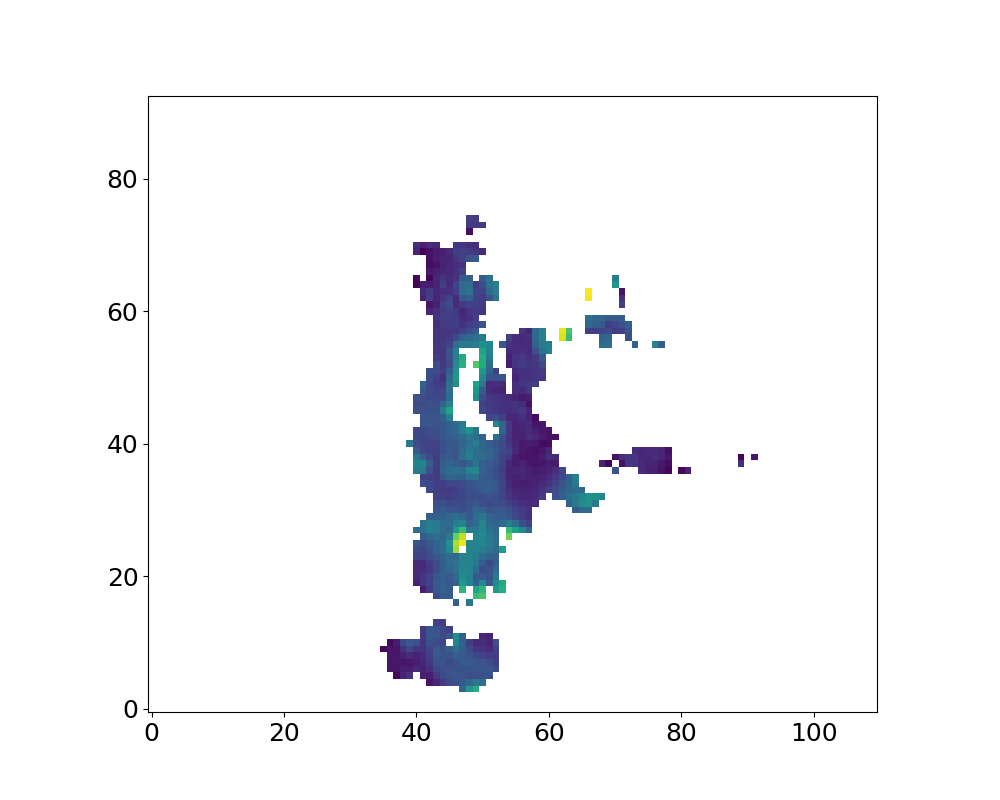

In [23]:
set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S

S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

plt.figure(figsize=(10,8))
plt.imshow(S_map_deb.data,origin='lower')
plt.show()

# set_delta = 0.5   # in arcminute
# S_map = BlankedMapPolAngle.copy()
# sigma_S_map = BlankedMapPolAngleError.copy()

# for i in range(RA_grid.shape[0]):
#     for j in range(RA_grid.shape[1]):

#         ##### seperation filter
#         seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
#         seperation_selector = (seperation.data<0.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data>1.5*set_delta)
#         seperation.data[seperation_selector] = np.nan
#         seperation_selector = (seperation.data >0)

#         ##### making the dispersion map
#         tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
#         tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
#         AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
#         S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
#         S_map.data[i,j] = S

#         ##### making the dispersion error map
#         N = np.sum(~np.isnan(seperation.data))
#         temp1 = ( ( BlankedMapPolAngleError.data[i,j]/( S_map.data[i,j]*N ) )**2)*(np.nansum(AngleDiff_v2[seperation_selector])**2)
#         temp2 = (BlankedMapPolAngleError.data*AngleDiff_v2)
#         temp3 = (( 1 /(S_map.data[i,j]*N) )**2)*( np.nansum( (temp2[seperation_selector])**2 ) )

#         sigma_S =  temp1 + temp3
#         sigma_S_map.data[i,j] = np.sqrt(sigma_S)
        
#         # np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
#         # sigma_S_map.data[i,j] = sigma_S

# S_map_deb = S_map.copy()
# S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

# plt.figure(figsize=(10,8))
# plt.imshow(sigma_S_map.data,origin='lower')
# plt.show()


synthetic data for dispersion 


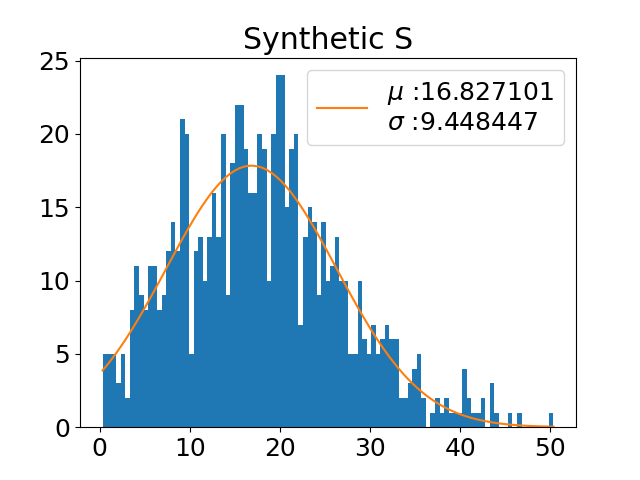

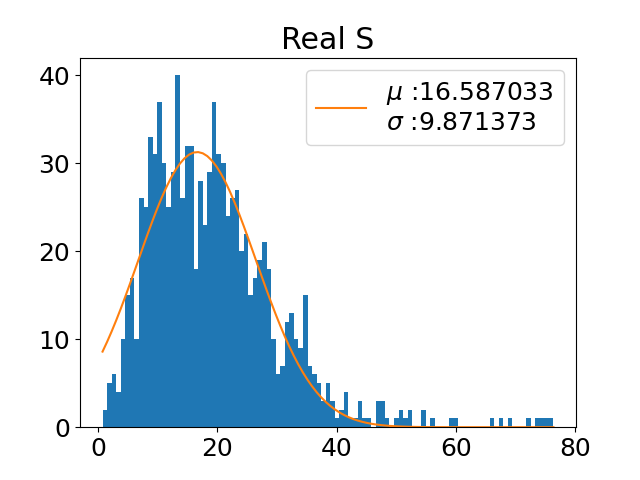

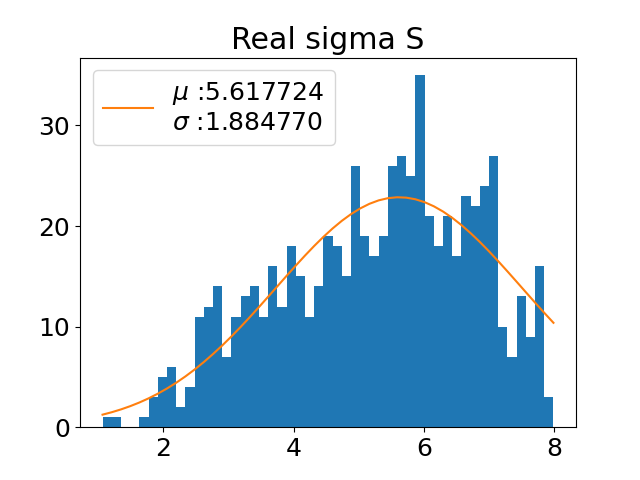

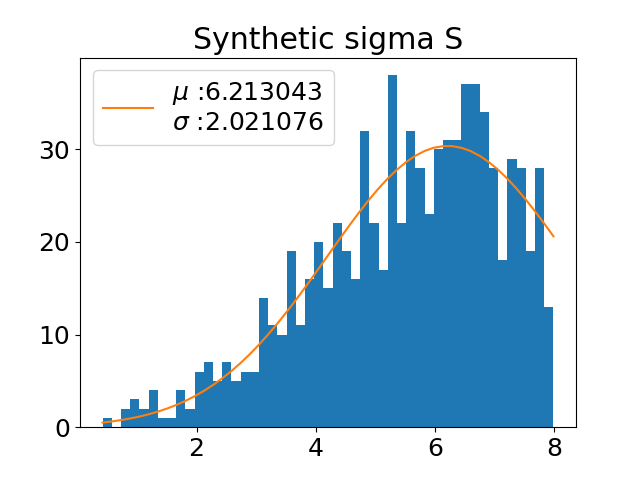

In [24]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)
    # return array,abin


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0) 
    # coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0,bounds=( (-np.inf,-np.inf,0), (np.inf,np.inf,np.inf))) 
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.6f}{linebreak}$\sigma$ :{std:.6f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))
    plt.legend()


s_array = S_map_deb.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()

s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
# s_array_ind = np.log(s_array_ind)

sigma_s_array_ind = sigma_s_array.copy()
sigma_s_array_ind = sigma_s_array_ind[::4]

syn_s_temp = np.random.normal(17,10,1000)
# syn_s_error= np.random.uniform(6,8,syn_s_temp.shape[0])
syn_s_error = np.random.normal(6,2,syn_s_temp.shape[0])

selector = (syn_s_temp < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error < 0)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan
selector = (syn_s_error > 8)
syn_s_temp[selector] = np.nan
syn_s_error[selector]= np.nan


df_s = pd.DataFrame({'syn_s': syn_s_temp,'syn_s_error':syn_s_error})
df_s = df_s.dropna()
gauss_fit(df_s['syn_s'],100)
plt.title('Synthetic S')
plt.show()

gauss_fit(s_array,100)
plt.title('Real S')
plt.show()

# plt.figure()
gauss_fit(sigma_s_array_ind,50)
plt.title('Real sigma S')
plt.show()

gauss_fit(syn_s_error,50)
plt.title('Synthetic sigma S')
plt.show()




Synthetic data for column density

-44.048376747645804


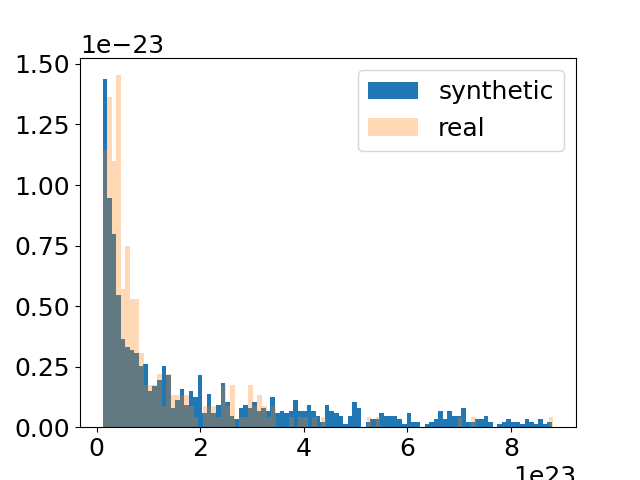

In [25]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

def powerlaw(x,*p):
    a,power = p
    return a*(x**(-1*power))

def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


def bin_generator(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    return array,abin

nh2_array = BlankedMapColumnDensity.data.flatten()
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
array_min = np.nanmin(nh2_array_ind)
nh2_array_ind = nh2_array_ind

nh2_min = np.nanmin(nh2_array_ind)
nh2_max = np.nanmax(nh2_array_ind)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)

hist, bin_edges = np.histogram(nh2_array_ind,nh2_bins)
temp_alpha = 1 + 1/(np.nanmean(np.log(nh2_array_ind/(np.nanmin(nh2_array_ind)))))
alpha = temp_alpha*0.65
print(1./(-1*alpha+1))
syn_nh2_temp = rndm(nh2_min,nh2_max, g=(-1*alpha+1), size=syn_s_temp.shape[0])
syn_nh2_error = syn_error(syn_nh2_temp)

plt.figure()
syn,syn_bin = bin_generator(syn_nh2_temp,100)
nh2,nh2_bin = bin_generator(nh2_array_ind,100)
plt.hist(syn,syn_bin,density=True,label='synthetic')
plt.hist(nh2,nh2_bin,density=True,alpha=0.3,label='real')
plt.legend()
plt.show()




Synthetic data for Pfrac

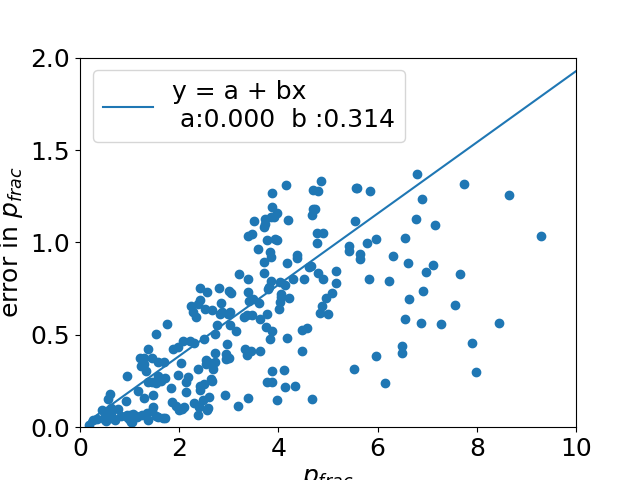

In [26]:
def lin_fit(x, a, b):
    return a + b*x

p_array = BlankedMapPol.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()

p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
p_error_array_ind = p_error_array.copy()
p_error_array_ind = p_error_array_ind[::4]

p_min = np.nanmin(p_array_ind)
p_max = np.nanmax(p_array_ind)
p_bins = np.linspace(p_min, p_max, 150)

selector = ~np.isnan(p_array_ind)
p_array_fil = p_array_ind[selector]
p_error_array_fil = p_error_array_ind[selector]

# selector = p_array_fil < 10
# p_array_fil = p_array_fil[selector]
# p_error_array_fil = p_error_array_fil[selector]


param, param_cov = curve_fit(lin_fit, p_array_fil, p_error_array_fil)
FitFunc = lin_fit(p_bins,0,param[1]+0.1)
# print(param)
plt.figure()
plt.scatter(p_array_fil, p_error_array_fil)
plt.plot(p_bins,FitFunc,label='y = a + bx{br} a:{a:.3f}{linebreak}b :{b:.3f}'.format(br='\n',linebreak='  ',a =0,b=param[0]+0.1))
plt.xlabel(r'$p_{frac}$')
plt.ylabel('error in '+r'$p_{frac}$')
plt.legend()
plt.xlim(0,10)
plt.ylim(0,2)
plt.tight_layout()
plt.show()

######## case with error in power and pfrac, S and NH2 Error order = 0.01
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error

# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))


# syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
# syn_p = syn_p_temp+syn_p_error


####### case with error in pfrac, S and NH2 Error order = 0.0001-0.00001
syn_s= syn_s_temp + syn_s_error
syn_nh2 = syn_nh2_temp + syn_nh2_error
syn_p_temp = 1e14*((syn_s)**(-1))*((syn_nh2)**(-0.5))
syn_p_error = syn_p_temp*(param[1]+0.1) + 0.093
syn_p = syn_p_temp+syn_p_error

######## case with error in power Error order = 0.01
# syn_s= syn_s_temp 
# syn_nh2 = syn_nh2_temp 
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp

######## case with error in power and S and NH2 Error order = 0.01
# syn_s= syn_s_temp + syn_s_error
# syn_nh2 = syn_nh2_temp + syn_nh2_error
# syn_s_power = np.random.normal(-1,0.01,syn_s.shape[0])
# syn_nh2_power = np.random.normal(-0.5,0.01,syn_s.shape[0])
# syn_p_temp = 1e14*((syn_s)**(syn_s_power))*((syn_nh2)**(syn_nh2_power))
# syn_p = syn_p_temp


# log_s = np.log10(syn_s)
# log_nh2 = np.log10(syn_nh2)
# log_p = np.log10(syn_p)

# plt.figure()
# plt.scatter(log_nh2,log_p)
# plt.show()


Doing bootstrap for the synthetic data

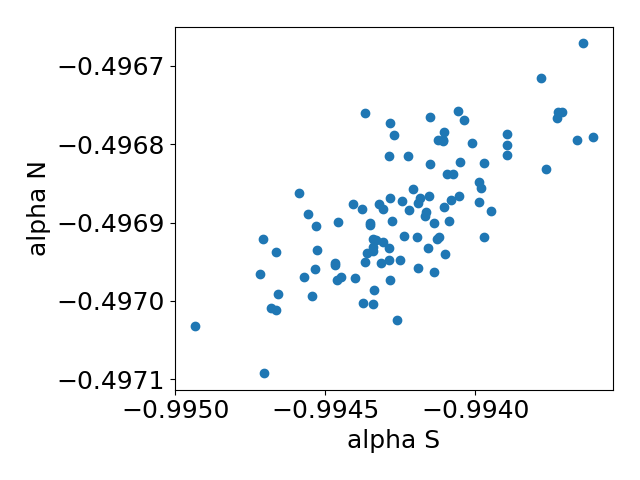

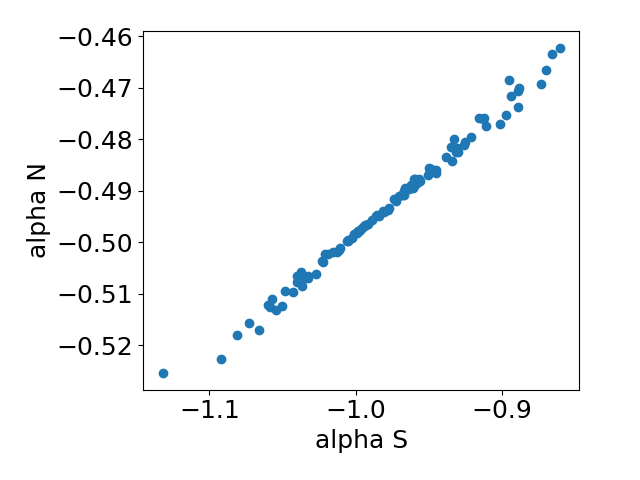

In [27]:
from scipy.stats import bootstrap as bootstrapscipy


array1 = np.log10(syn_s)
log_nh2 = np.log10(syn_nh2)
log_p = np.log10(syn_p)

df_log = pd.DataFrame({'logp': log_p,'logs':array1,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y


def curve_fitting(x):

    param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
    return param
    # return [param,np.sqrt(np.diag(param_cov))]




bootresult = bootstrap(bootarr,100,bootfunc=curve_fitting)
# print(bootresult)


plt.figure()
plt.scatter(bootresult[:,1],bootresult[:,2])
plt.ylabel('alpha N')
plt.xlabel('alpha S')
plt.tight_layout()
plt.show()


# gauss_fit(bootresult[:,1],100)
# plt.title('astropy bootstrap synthetic S')
# plt.show()

# gauss_fit(bootresult[:,2],100)
# plt.title('astropy bootstrap synthetic N')
# plt.show()


# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[2]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# # fig, ax = plt.subplots()
# # ax.hist(res.bootstrap_distribution, bins=25)
# # ax.set_title('Bootstrap Distribution')
# # ax.set_xlabel('statistic value')
# # ax.set_ylabel('frequency')
# # plt.show()


# gauss_fit(res.bootstrap_distribution,50)
# plt.title('scipy bootstrap synthetic N')
# plt.show()

# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[1]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)

# gauss_fit(res.bootstrap_distribution,50)
# plt.title('scipy bootstrap synthetic S')
# plt.show()


def alpha_distribution(x):
    param1, param_cov = curve_fit(lin_fit,x[:,1],x[:,0])
    param2, param_cov = curve_fit(lin_fit,x[:,2],x[:,0])

    return np.array([param1[1],param2[1]])
    # return np.sqrt(np.diag(param_cov))



bootresult = bootstrap(bootarr,100,bootfunc=alpha_distribution)
# print(bootresult)

plt.figure()
plt.scatter(bootresult[:,0],bootresult[:,1])
plt.xlabel('alpha S')
plt.ylabel('alpha N')
plt.tight_layout()
plt.show()



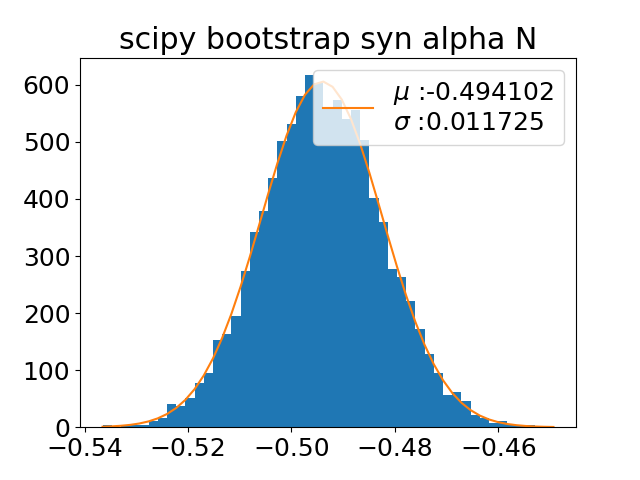

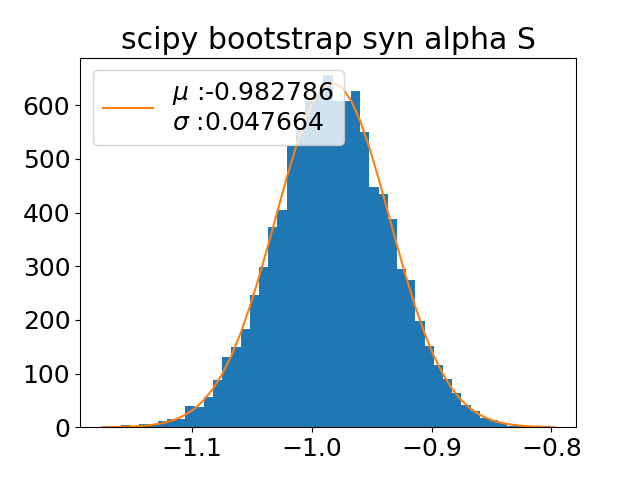

In [28]:
def lin_fit(x, a, b):
    return a + b*x

def my_statistic(x,y):
    param, param_cov = curve_fit(lin_fit,x,y)
    return param[1]
    # return np.sqrt(np.diag(param_cov))



# print(my_statistic(bootarr))
res = bootstrapscipy((bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


gauss_fit(res.bootstrap_distribution,50)
plt.title('scipy bootstrap syn alpha N')
plt.show()



# print(my_statistic(bootarr))
res = bootstrapscipy((bootarr[:,1],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


gauss_fit(res.bootstrap_distribution,50)
plt.title('scipy bootstrap syn alpha S')
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3228179390.py:45: RuntimeWarning: Mean of empty slice
  p[k,l] = np.nanmean(tempp)


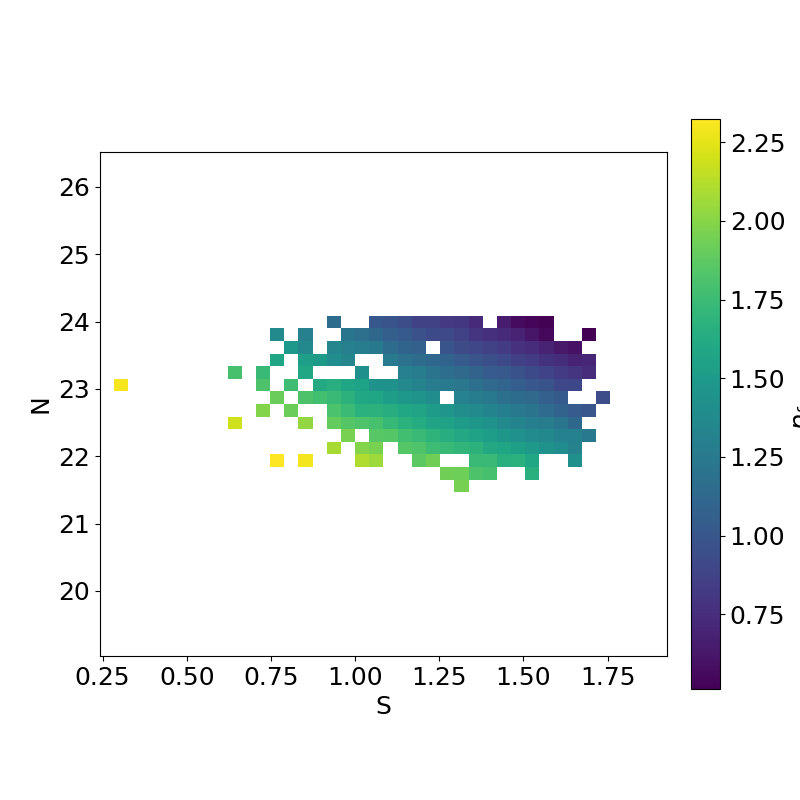

(40, 40)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3228179390.py:67: RuntimeWarning: Mean of empty slice
  grid3[k,l] = np.nanmean(temp3)


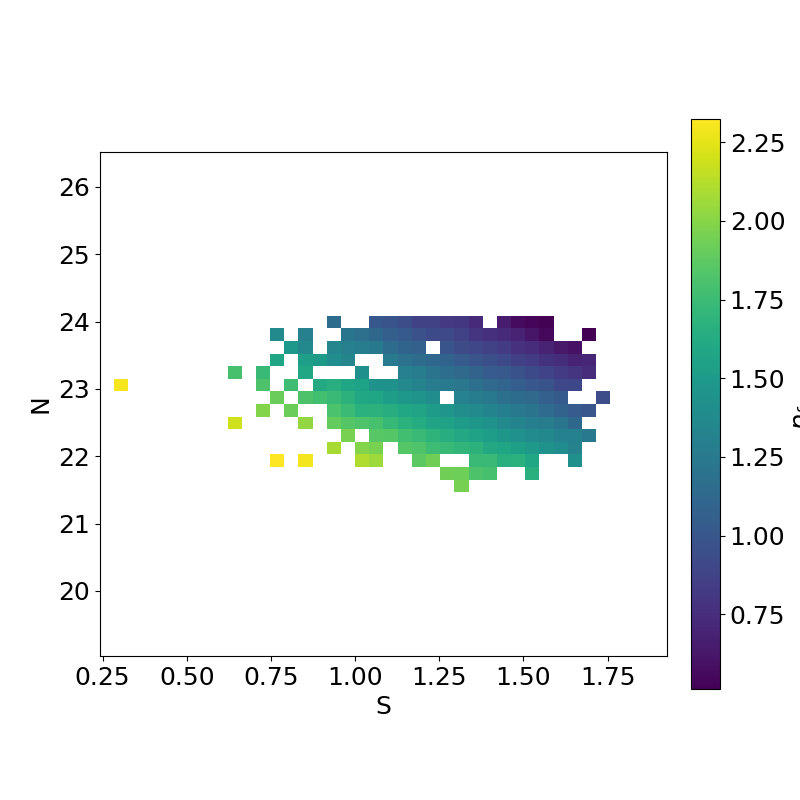

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

log_s = np.log10(syn_s)
log_nh2 = np.log10(syn_nh2)
log_p = np.log10(syn_p)

nh2array = np.linspace(np.nanmin(log_nh2)/1.1,np.nanmax(log_nh2)*1.1,40)
sarray = np.linspace(np.nanmin(log_s)/1.1,np.nanmax(log_s)*1.1,40)

sgrid,nh2grid = np.meshgrid(sarray,nh2array)
nh2delt = nh2array[1] - nh2array[0]
sdelt = sarray[1] - sarray[0]

p = np.ones_like(sgrid)*np.nan

# print(p.shape)
# plt.figure()
# plt.imshow(sgrid)
# plt.show()

# plt.figure()
# plt.imshow(nh2grid)
# plt.show()

for k in range(nh2array.shape[0]):
    for l in range(sarray.shape[0]):
    
        tempnh2 = log_nh2.copy()
        temps = log_s.copy()
        tempp = log_p.copy()

        # print(tempp)
        selector = abs(nh2array[k] - log_nh2) > nh2delt/2
        tempnh2[selector] = np.nan
        temps[selector]=np.nan
        tempp[selector] = np.nan
        # print(tempp)

        selector = abs(sarray[l] - log_s) > sdelt/2
        tempnh2[selector] = np.nan
        temps[selector]=np.nan
        tempp[selector] = np.nan
        # print(tempp)

        p[k,l] = np.nanmean(tempp)


def hist3d(array1,array2,array3,delt1,delt2):
    linspace1 = np.linspace((np.nanmin(array1)/1.1),np.nanmax(array1)*1.1,delt1)
    linspace2 = np.linspace((np.nanmin(array2)/1.1),np.nanmax(array2)*1.1,delt2)

    del1 = linspace1[1] - linspace1[0]
    del2 = linspace2[1] - linspace2[0]

    grid3 = np.ones((linspace1.shape[0],linspace2.shape[0]))*np.nan
    print(grid3.shape)
    for l in range(linspace1.shape[0]):
        for k in range(linspace2.shape[0]):
            temp3 = array3.copy()

            selector = abs(linspace2[k] - array2) > del2/2
            temp3[selector] = np.nan

            selector = abs(linspace1[l] - array1) > del1/2
            temp3[selector] = np.nan

            grid3[k,l] = np.nanmean(temp3)

    return grid3,linspace1,linspace2

plt.figure(figsize=(8,8))
plt.imshow(p,origin='lower',extent =[np.nanmin(sarray),np.nanmax(sarray),np.nanmin(nh2array),np.nanmax(nh2array)] ,aspect = .2)
# plt.imshow(p,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04,label=r'$p_{frac}$')
plt.xlabel('S')
plt.ylabel('N')

# plt.tight_layout()
plt.show()

p2,linspace1,linspace2 = hist3d(log_s,log_nh2,log_p,40,40)
plt.figure(figsize=(8,8))
plt.imshow(p2,origin='lower',extent =[np.nanmin(linspace1),np.nanmax(linspace1),np.nanmin(linspace2),np.nanmax(linspace2)] ,aspect = .2)
# plt.imshow(p,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04,label=r'$p_{frac}$')
plt.xlabel('S')
plt.ylabel('N')

# plt.tight_layout()
plt.show()




In [30]:

# def hist3d(array1,array2,array3,delt1,delt2):
#     nh2array = np.linspace(np.nanmin(array2)/1.1,np.nanmax(array2)*1.1,delt2)
#     sarray = np.linspace(np.nanmin(array1)/1.1,np.nanmax(array1)*1.1,delt1)

#     sgrid,nh2grid = np.meshgrid(sarray,nh2array)
#     nh2delt = nh2array[1] - nh2array[0]
#     sdelt = sarray[1] - sarray[0]

#     p = np.ones_like(sgrid)*np.nan

#     print(p.shape)
#     # plt.figure()
#     # plt.imshow(sgrid)
#     # plt.show()

#     # plt.figure()
#     # plt.imshow(nh2grid)
#     # plt.show()

#     for k in range(nh2array.shape[0]):
#         for l in range(sarray.shape[0]):
        
#             tempnh2 = array2.copy()
#             temps = array1.copy()
#             tempp = array3.copy()

#             # print(tempp)
#             selector = abs(nh2array[k] - array2) > nh2delt/2
#             tempnh2[selector] = np.nan
#             temps[selector]=np.nan
#             tempp[selector] = np.nan
#             # print(tempp)

#             selector = abs(sarray[l] - array1) > sdelt/2
#             tempnh2[selector] = np.nan
#             temps[selector]=np.nan
#             tempp[selector] = np.nan
#             # print(tempp)

#             p[k,l] = np.nanmean(tempp)

#     return p,nh2array,sarray

# plt.figure()
# ax = plt.gca()
# # im = ax.imshow(p,origin='lower',extent =[np.nanmin(log_nh2)/1.1,np.nanmax(log_nh2)*1.1,np.nanmin(log_s)/1.1,np.nanmax(log_s)*1.1] )

# im = ax.imshow(p,origin='lower')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# plt.show()


# p,sarray,nh2array = hist3d(log_s,log_nh2,log_p,40,40)


In [31]:
# from scipy.stats import bootstrap as bootstrapscipy


# log_s = np.log10(syn_s)
# log_nh2 = np.log10(syn_nh2)
# log_p = np.log10(syn_p)

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
# df_log = df_log.dropna()
# bootarr = np.array(df_log)


# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[2]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


# gauss_fit(res.bootstrap_distribution,50)
# plt.show()



In [32]:

# log_s = np.log10(syn_s)
# log_nh2 = np.log10(syn_nh2)
# log_p = np.log10(syn_p)

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
# df_log = df_log.dropna()
# bootarr = np.array(df_log)



# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[1]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()

# gauss_fit(res.bootstrap_distribution,50)
# plt.show()

In [33]:
# def DoubleParamFunc(X, a, b, c):
#     x,y = X
#     return a + b*x + c*y

# df = pd.DataFrame({'syn_s': np.log10(syn_s),'syn_nh2':np.log10(syn_nh2),'syn_p':np.log10(syn_p)})
# df = df.dropna()


# p0 = -0.2278, -0.8567, 2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df['syn_s'],df['syn_nh2']),df['syn_p'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('nh2 index :',PSI_param_lower[2])

working with real data

[[10.52650388 -0.29681021 -0.42608532]
 [10.72909941 -0.29429417 -0.43477195]
 [11.0320449  -0.29685946 -0.44815617]
 [10.07032877 -0.30305977 -0.40521879]
 [10.87599787 -0.30469257 -0.4412852 ]
 [10.43776603 -0.34926647 -0.41974021]
 [10.6794623  -0.36151718 -0.42902576]
 [11.55412109 -0.24565848 -0.47420711]
 [10.69476401 -0.39930997 -0.42758465]
 [10.82851824 -0.2799253  -0.44003046]
 [10.28645438 -0.35838022 -0.41232171]
 [10.41331059 -0.30249424 -0.42074859]
 [10.54508314 -0.33606899 -0.42512379]
 [10.72234155 -0.27973938 -0.43474477]
 [10.9279896  -0.36412339 -0.4403407 ]
 [11.69141383 -0.3124015  -0.47675624]
 [10.43933009 -0.39257564 -0.41719474]
 [11.79174835 -0.23924037 -0.48407049]
 [ 9.91968524 -0.36568739 -0.39558075]
 [11.00250989 -0.35827649 -0.44367941]
 [10.3794156  -0.29969844 -0.41954728]
 [10.62939586 -0.25482001 -0.43247111]
 [10.76755485 -0.31100665 -0.4358806 ]
 [10.64984309 -0.32001242 -0.42994583]
 [10.23524678 -0.30358289 -0.41270351]
 [11.3083996  -0.24807263

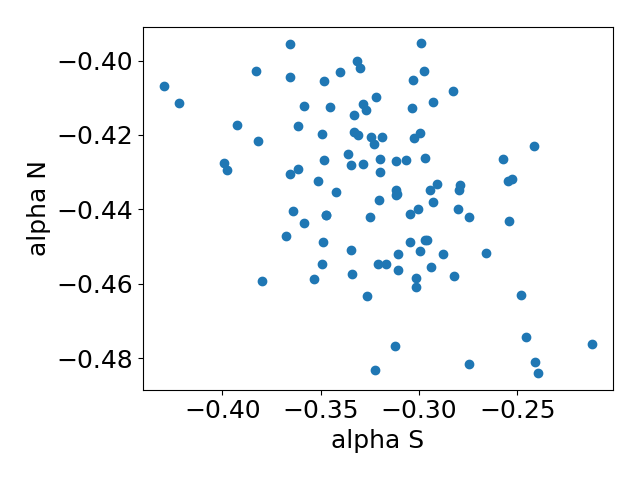

In [34]:
def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])


p_array = BlankedMapPol.data.flatten()
s_array = S_map_deb.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()
syn_nh2_error = syn_error(nh2_array)


log_s = np.log10(s_array)
log_nh2 = np.log10(nh2_array)
log_p = np.log10(p_array)

# plt.figure()
# plt.scatter(log_nh2,log_p)
# plt.show()


df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y


def curve_fitting(x):

    param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
    return param
    # return [param,np.sqrt(np.diag(param_cov))]




bootresult = bootstrap(bootarr,100,bootfunc=curve_fitting)
print(bootresult)


plt.figure()
plt.scatter(bootresult[:,1],bootresult[:,2])
plt.ylabel('alpha N')
plt.xlabel('alpha S')
plt.tight_layout()
plt.show()



# print(bootarr.shape)
# bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
# print(bootresult)

# def alpha_distribution(x):
#     param1, param_cov = curve_fit(lin_fit,x[:,1],x[:,0])
#     param2, param_cov = curve_fit(lin_fit,x[:,2],x[:,0])

#     return np.array([param1[1],param2[1]])
#     # return np.sqrt(np.diag(param_cov))



# bootresult = bootstrap(bootarr,100,bootfunc=alpha_distribution)
# # print(bootresult)

# plt.figure()
# plt.scatter(bootresult[:,1],bootresult[:,2])
# plt.xlabel('alpha S')
# plt.ylabel('alpha N')
# plt.tight_layout()
# plt.show()




# bootarr = np.array(df_log)


# bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
# # print(bootresult)


# gauss_fit(bootresult[:,1],100)
# plt.title('astropy bootstrap real S')
# plt.show()

# gauss_fit(bootresult[:,2],100)
# plt.title('astropy bootstrap real N')
# plt.show()


# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[2]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# # fig, ax = plt.subplots()
# # ax.hist(res.bootstrap_distribution, bins=25)
# # ax.set_title('Bootstrap Distribution')
# # ax.set_xlabel('statistic value')
# # ax.set_ylabel('frequency')
# # plt.show()


# gauss_fit(res.bootstrap_distribution,50)
# plt.title('scipy bootstrap real N')
# plt.show()

# def my_statistic(x,y,z):
#     param, param_cov = curve_fit(DoubleParamFunc,(x,y),z)

#     # param, param_cov = curve_fit(DoubleParamFunc,(x[:,1],x[:,2]),x[:,0])
#     return param[1]

# # print(my_statistic(bootarr))
# res = bootstrapscipy((bootarr[:,1],bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)

# gauss_fit(res.bootstrap_distribution,50)
# plt.title('scipy bootstrap real S')
# plt.show()


# def hist3d(array1,array2,array3,delt1,delt2):
#     linspace1 = np.linspace((np.nanmin(array1)-2),(np.nanmax(array1)+2),delt1)
#     linspace2 = np.linspace((np.nanmin(array2)-2),(np.nanmax(array2)+2),delt2)

#     del1 = linspace1[1] - linspace1[0]
#     del2 = linspace2[1] - linspace2[0]

#     grid3 = np.ones((linspace1.shape[0],linspace2.shape[0]))*np.nan
#     print(grid3.shape)
#     for l in range(linspace1.shape[0]):
#         for k in range(linspace2.shape[0]):
#             temp3 = array3.copy()

#             selector = (abs(linspace2[k] - array2) > del2/2)|(abs(linspace1[l] - array1) > del1/2)
#             temp3[selector] = np.nan

#             grid3[l,k] = np.nanmean(temp3)
#             # plt.figure()
#             # plt.imshow(grid3)
#             # plt.show()

#     return grid3,linspace1,linspace2


# p,linspace1,linspace2 = hist3d(df_log["logs"],df_log["lognh2"],df_log["logp"],30,30)
# plt.figure(figsize=(8,8))
# plt.imshow(p,origin='lower',extent =[np.nanmin(linspace1),np.nanmax(linspace1),np.nanmin(linspace2),np.nanmax(linspace2)])
# # plt.imshow(p,origin='lower')
# plt.colorbar(fraction=0.046, pad=0.04,label=r'$p_{frac}$')
# plt.xlabel('S')
# plt.ylabel('N')
# plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3143779814.py:20: RuntimeWarning: Mean of empty slice
  grid3[l,k] = np.nanmean(temp3)                                                         # Putting the average value of array3 data
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3143779814.py:20: RuntimeWarning: Mean of empty slice
  grid3[l,k] = np.nanmean(temp3)                                                         # Putting the average value of array3 data
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3143779814.py:20: RuntimeWarning: Mean of empty slice
  grid3[l,k] = np.nanmean(temp3)                                                         # Putting the average value of array3 data
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3143779814.py:20: RuntimeWarning: Mean of empty slice
  grid3[l,k] = np.nanmean(temp3)                                                         # Putting the average value of array3 data
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3143779814.

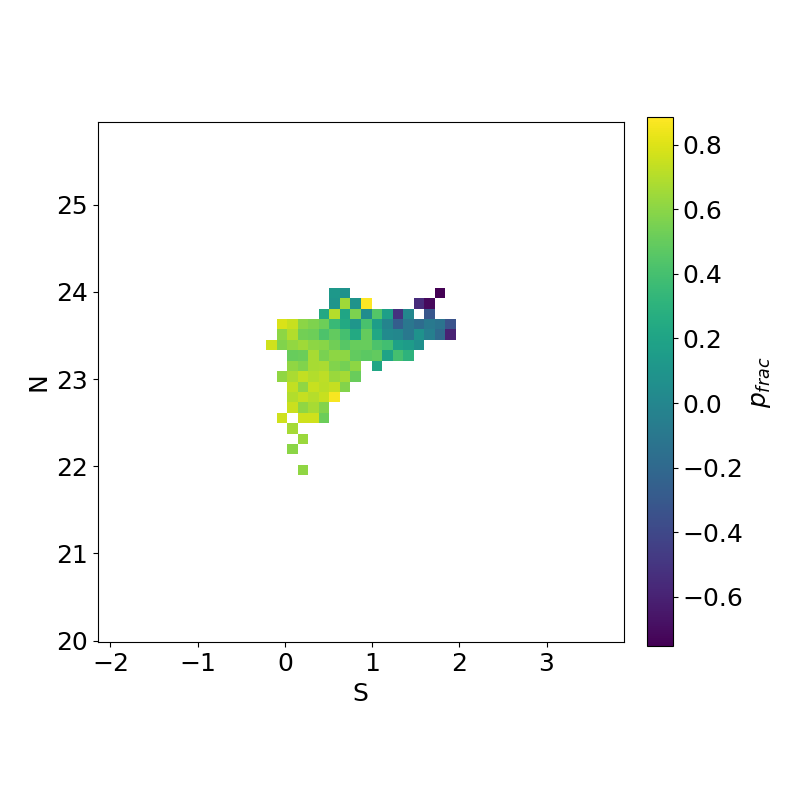

In [35]:
def hist3d(array1,array2,array3,delt1,delt2):
    linspace1 = np.linspace((np.nanmin(array1)-2),(np.nanmax(array1)+2),delt1) #creating the bins for array 1
    linspace2 = np.linspace((np.nanmin(array2)-2),(np.nanmax(array2)+2),delt2) #creating the bins for array 2

    del1 = linspace1[1] - linspace1[0]                                         #Calculate the increment size in bins 1
    del2 = linspace2[1] - linspace2[0]                                         #Calculate the increment size in bins 1

    grid3 = np.ones((linspace1.shape[0],linspace2.shape[0]))*np.nan            #create a grid of size bins1 x bins2
    # print(grid3.shape)
    for l in range(linspace1.shape[0]):
        for k in range(linspace2.shape[0]):                                    # run a nested loop over the grid
            temp3 = array3.copy()

            selector = (abs(linspace2[k] - array2) > del2/2)|(abs(linspace1[l] - array1) > del1/2) # choose the values in array3
                                                                                                   # that don't lie in the grid square

            temp3[selector] = np.nan                                                               # make those array3 values nan leaving only the 
                                                                                                   # data that we need

            grid3[l,k] = np.nanmean(temp3)                                                         # Putting the average value of array3 data 
            # plt.figure()
            # plt.imshow(grid3)
            # plt.show()

    return grid3,linspace1,linspace2


p,linspace1,linspace2 = hist3d(df_log["logs"],df_log["lognh2"],df_log["logp"],50,50)
plt.figure(figsize=(8,8))
plt.imshow(p,origin='lower',extent =[np.nanmin(linspace1),np.nanmax(linspace1),np.nanmin(linspace2),np.nanmax(linspace2)])
# plt.imshow(p,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04,label=r'$p_{frac}$')
plt.xlabel('S')
plt.ylabel('N')
plt.tight_layout()
plt.show()


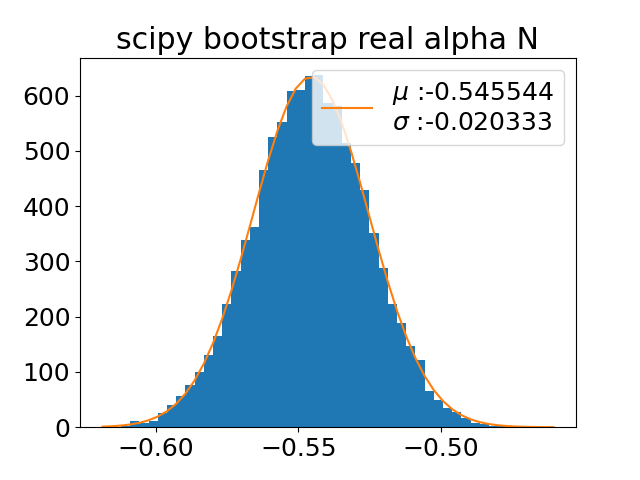

KeyboardInterrupt: 

In [36]:

def lin_fit(x, a, b):
    return a + b*x

def my_statistic(x,y):
    param, param_cov = curve_fit(lin_fit,x,y)
    return param[1]
    # return np.sqrt(np.diag(param_cov))



# print(my_statistic(bootarr))
res = bootstrapscipy((bootarr[:,2],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


gauss_fit(res.bootstrap_distribution,50)
plt.title('scipy bootstrap real alpha N')
plt.show()



# print(my_statistic(bootarr))
res = bootstrapscipy((bootarr[:,1],bootarr[:,0]), my_statistic, vectorized=False, paired=True,n_resamples=10000)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


gauss_fit(res.bootstrap_distribution,50)
plt.title('single parameter scipy bootstrap real alpha S')
plt.show()



C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3146061362.py:37: RuntimeWarning: Mean of empty slice
  bin_centres.append(np.nanmean(temp_array1))
C:\Users\DELL\AppData\Local\Temp\ipykernel_13036\3146061362.py:38: RuntimeWarning: Mean of empty slice
  binned_data.append(np.nanmean(temp_array2))
c:\Users\DELL\anaconda3\envs\polarimetry\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


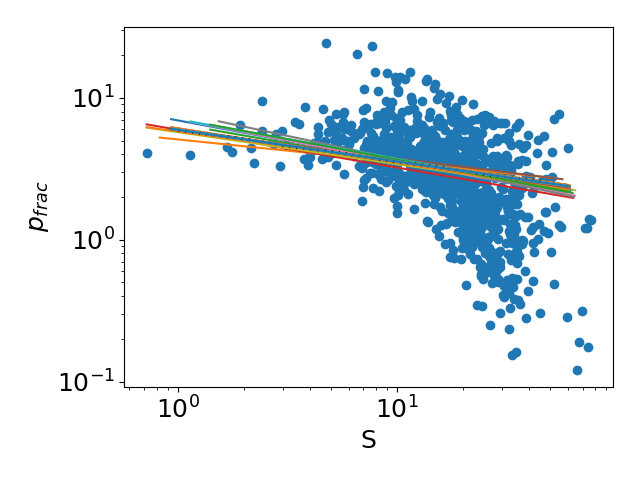

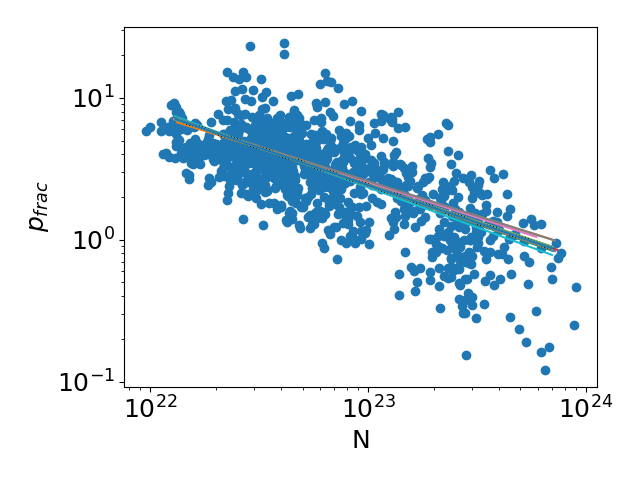

In [ ]:
def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil

def binning_equal_width_bootstrap(x,y,Nbins = 11):
    array1 = x
    array2 = y

    filtered1,filtered2 = remove_nan(array1,array2)
    log_filtered1 = np.log10(filtered1)
    log_filtered2 = np.log10(filtered2)

    bins = np.linspace(np.nanmin(log_filtered1),np.nanmax(log_filtered1),Nbins)
    # bin_centres = (bins[:-1] + bins[1:])/2

    bin_centres = []
    binned_data = []
    error_bar = []

    for i in range(0,(bins.shape[0]-1)):
        temp_array1 = filtered1.copy()
        temp_array2 = filtered2.copy()

        Selector = log_filtered1 < bins[i]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        Selector =  log_filtered1 > bins[i+1]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan

        bin_centres.append(np.nanmean(temp_array1))
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(temp_array2))

    bin_centres = np.log10(np.array(bin_centres))
    binned_data = np.log10(np.array(binned_data))
    bin_centres,binned_data = remove_nan(bin_centres,binned_data)

    # param, PS_param_cov = curve_fit(lin_fit, bin_centres, binned_data)

    param, param_cov = curve_fit(lin_fit, bin_centres, binned_data)
    level_bins = np.linspace(np.amin(bin_centres),np.amax(bin_centres),10)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    plt.plot(10**level_bins,10**PS_FitFunc)
    # return np.sqrt(np.diag(param_cov))
    return param[1]

# print(binning_equal_width_bootstrap(s_array,p_array))

p_array = BlankedMapPol.data.flatten()
s_array = S_map_deb.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()
syn_nh2_error = syn_error(nh2_array)


# print(my_statistic(bootarr))
plt.figure()
plt.scatter(s_array,p_array)
res = bootstrapscipy((s_array,p_array), binning_equal_width_bootstrap, vectorized=False, paired=True,n_resamples=10)
plt.xlabel('S')
plt.ylabel(r'$p_{frac}$')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(nh2_array,p_array)
res = bootstrapscipy((nh2_array,p_array), binning_equal_width_bootstrap, vectorized=False, paired=True,n_resamples=10)
plt.ylabel(r'$p_{frac}$')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()


# gauss_fit(res.bootstrap_distribution,50)
# # plt.title('scipy bootstrap real alpha N')
# plt.show()


# # print(my_statistic(bootarr))
# res = bootstrapscipy((nh2_array,p_array), binning_equal_width_bootstrap, vectorized=False, paired=True,n_resamples=10)
# # fig, ax = plt.subplots()
# # ax.hist(res.bootstrap_distribution, bins=25)
# # ax.set_title('Bootstrap Distribution')
# # ax.set_xlabel('statistic value')
# # ax.set_ylabel('frequency')
# # plt.show()


# gauss_fit(res.bootstrap_distribution,50)
# # plt.title('scipy bootstrap real alpha N')
# plt.show()

